In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from glob import glob
from scipy import stats

import os
from os import path

from photutils import centroid_com, centroid_1dg, centroid_2dg, aperture_photometry,EllipticalAperture, DAOStarFinder
from photutils import EllipticalAnnulus,RectangularAnnulus,RectangularAperture,CircularAperture, CircularAnnulus
from photutils.isophote import EllipseGeometry, Ellipse

from astropy.wcs import WCS
from astropy.stats import mad_std,sigma_clip,sigma_clipped_stats
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
from astropy.io import fits

sns.set()
plt.rcParams['figure.figsize'] = [15, 10]

<ipython-input-1-cf918ee5bb99>:10: DeprecationWarning: `photutils.centroid_com` is a deprecated alias for `photutils.centroids.centroid_com`. Instead, please use `from photutils.centroids import centroid_com` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg, aperture_photometry,EllipticalAperture, DAOStarFinder
<ipython-input-1-cf918ee5bb99>:10: DeprecationWarning: `photutils.centroid_1dg` is a deprecated alias for `photutils.centroids.centroid_1dg`. Instead, please use `from photutils.centroids import centroid_1dg` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg, aperture_photometry,EllipticalAperture, DAOStarFinder
<ipython-input-1-cf918ee5bb99>:10: DeprecationWarning: `photutils.centroid_2dg` is a deprecated alias for `photutils.centroids.centroid_2dg`. Instead, please use `from photutils.centroids import centroid_2dg` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centro

In [2]:
def master(name):
    lis = glob(name)
    dat = []
    for file in lis:
        image = fits.open(file)
        dat.append(image[0].data)
    
    return np.median(dat, axis=0)

def starfind(source):
    im = fits.getdata(source)
    master_std = mad_std(im)
    masterdaofind = DAOStarFinder(fwhm=9., threshold= 10*master_std)
    mastersources = masterdaofind(im)
    mags = mastersources['mag']
    
    #finds index of the brightest star (min magnitude)
    ind = np.where(mags== np.min(mags))[0]

    return mastersources['xcentroid'][ind], mastersources['ycentroid'][ind]
    
    

def source_align(source,targetnames,new,path1,path2):
    targets = glob(targetnames)
    xs,ys = starfind(source)
    i = 0
    while i < len(targets):
        os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/{}'.format(path1))
        dat = fits.getdata(targets[i])
    
        x,y = starfind(targets[i])

        dx = int(x-xs)
        dy = int(y-ys)
        
        xrolled = np.roll(dat, -dx, axis=1)
        dat_new = np.roll(xrolled, -dy, axis=0)
        
        os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/{}'.format(path2))
        
        name = '{}_al_0{}'.format(new,i+1)
        
        im = dat_new
        hdu = fits.PrimaryHDU(im)
        hdul = fits.HDUList([hdu])
        hdul.writeto(name+'.fits', overwrite = True)
        i += 1

        
    return    


In [3]:
def rename(path,new):
    i= 0
    lis = os.listdir(path)
    
    while i < len(lis):
        
        dat = fits.getdata(lis[i])
        
        #writing the new files
        
        name = '{}_0{}'.format(new,i+1)
        
        hdu = fits.PrimaryHDU(dat)
        hdul = fits.HDUList([hdu])
        hdul.writeto(name+'.fits', overwrite = True)
        i += 1
        
    return 

In [4]:
def biassubflat(flat,path1,path2): 
    i = 0 
    
    lisf = glob(flat)
    
    os.chdir(r'C:\Users\laura\Documents\4th year\Thesis\Rough work\bias')
    lisb = glob('bias*')
    while i < len(lisf):

        os.chdir(r'{}'.format(path1))
        f_d  = CCDData(fits.getdata(lisf[i]).data, unit=u.adu)
        fd_trim = ccdproc.trim_image(f_d[100:2000,50:2000])
        os.chdir(r'C:\Users\laura\Documents\4th year\Thesis\Rough work\bias')
        b_d = CCDData(fits.getdata(lisb[i]).data, unit=u.adu)
        bd_trim = ccdproc.trim_image(b_d[100:2000,50:2000])

        sub =  np.array(fd_trim)  - np.array(bd_trim) 
        
        #writing the new files
        os.chdir(r'C:\Users\laura\Documents\4th year\Thesis\Rough work\sub\{}'.format(path2))
        name = 'bflat_0{}'.format(i+1)
        
        hdu = fits.PrimaryHDU(sub)
        hdul = fits.HDUList([hdu])
        hdul.writeto(name+'.fits', overwrite = True)
        i += 1
        
    return 

In [5]:
os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/bias')
masterbias = fits.getdata('masterbias.fits')
os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/flats/flat_v')
nmasterf_v = fits.getdata('nmasterf_v.fits')
os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/flats/flat_b')
nmasterf_b = fits.getdata('nmasterf_b.fits')

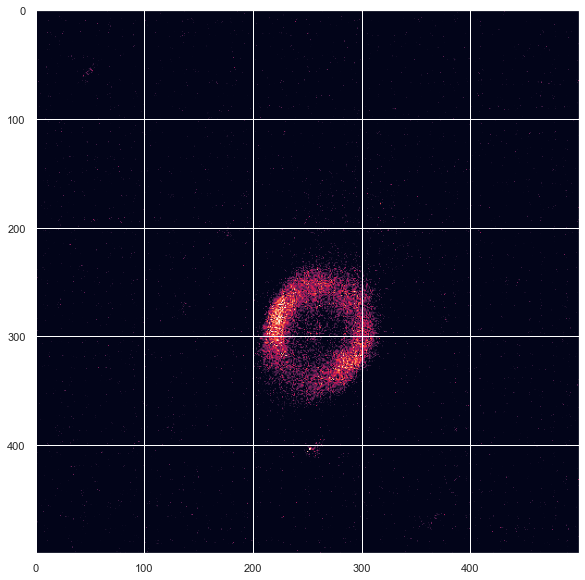

In [129]:
os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/lco_data-20220324-8')
#rename('C:/Users/laura/Documents/4th year/Thesis/Rough work/lco_data-20220324-8','im')
# image = master('M57_al*')
# lis = glob('im*')
# for i in range(0,len(lis)):
#     dat = fits.getdata(lis[i])
#     av = np.median(dat[980:1100,1450:1570])
#     trim = dat[750:1250,1250:1750]
#     trima = trim/av
#     hdu = fits.PrimaryHDU(trima)
#     hdul = fits.HDUList([hdu])
#     name = 'trim_0{}'.format(i+1)
#     hdul.writeto(name+'.fits', overwrite = True)


#source_align('trim_01.fits','trim*','M57','lco_data-20220324-8','lco_data-20220324-8')

plt.imshow(image,vmin =  0.998,vmax = 1.02)



(<Column name='xcentroid' dtype='float64' length=1>
 494.8773188685555,
 <Column name='ycentroid' dtype='float64' length=1>
 494.86570425182447)

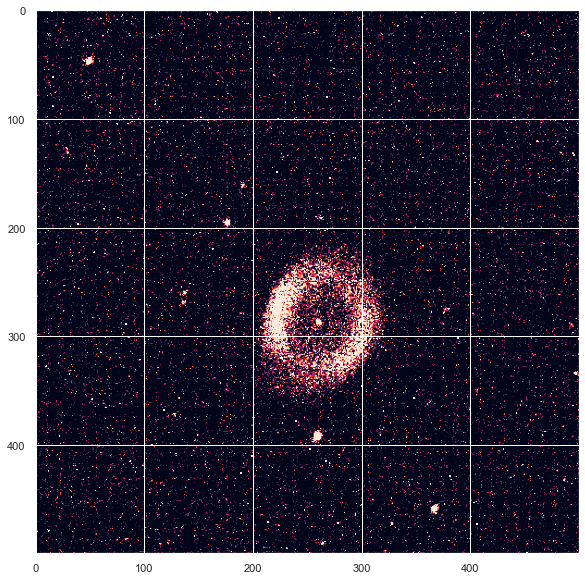

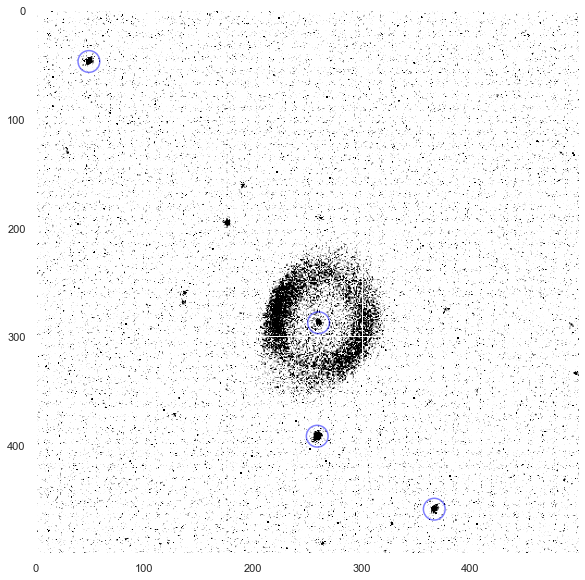

In [107]:
mean, median, std = sigma_clipped_stats(d, sigma=5.0)

daofind = DAOStarFinder(fwhm=8.0, threshold = 10*std ) 
sources = daofind(d - median)


from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=10.) #choose a number large enough to go over the stars
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(d,vmin = 0.997,vmax = 1.01,cmap = 'Greys')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [6]:
# equations based on luptons algorithm
#sloan are better than johnson --. no overlap between filter wavelengths
#take ha to be r and OIII to be g
# B = u - 0.8116*(u - g) + 0.1313;  sigma = 0.0095
# B = g + 0.3130*(g - r) + 0.2271;  sigma = 0.0107
# V = g - 0.2906*(u - g) + 0.0885;  sigma = 0.0129
# V = g - 0.5784*(g - r) - 0.0038;  sigma = 0.0054

def sloan_mag(B,V):
    #take eq 4 from eq 2 to get value for g-r
    g_r = (B-V -0.2309)/0.8914
    
    #sub back in to eq 2
    g = (B -0.2271)-(g_r*0.313)
    
    #use g-r to find r mag
    r = g - (B-V -0.2309)/0.8914
    return r,g
    
    


In [7]:
os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/M27_data/b2')
# lis = glob('im*')
# for i in range (0,len(lis)):
#     d = fits.getdata(lis[i])
#     im_n = CCDData(d, unit=u.adu)
#     im_trim = ccdproc.trim_image(im_n[350:1750,700:2500])
#     im = np.array(im_trim)
#     av = np.median(im_n[700:800,700:800])
#     print(av)
#     trima = im/av
#     hdu = fits.PrimaryHDU(trima)
#     hdul = fits.HDUList([hdu])
#     name = 'trim_0{}'.format(i+1)
#     hdul.writeto(name+'.fits', overwrite = True)
# image = master('trim*')

source_align('trim_01.fits','trim*','M27','M27_data/b2','M27_data/b2')
trima = im/av
hdu = fits.PrimaryHDU(trima)
hdul = fits.HDUList([hdu])
hdul.writeto('master_M27_B.fits', overwrite = True)
plt.imshow(trima,vmin=0.98,vmax =1.1)
#tot_db = fits.getdata('master_M27_B.fits')
# trima = master('M27_al*')
# hdu = fits.PrimaryHDU(trima)
# hdul = fits.HDUList([hdu])
# name = 'master_M27_B'
# hdul.writeto(name+'.fits', overwrite = True)
# plt.imshow(tot_db[700:800,700:800],vmin =  1.05,vmax = 1.2)
# plt.colorbar()

# plt.title('M27 B Filter',fontsize = 20)
# os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/images')
# plt.savefig('M27_B.png')
# plt.show()

NameError: name 'im' is not defined

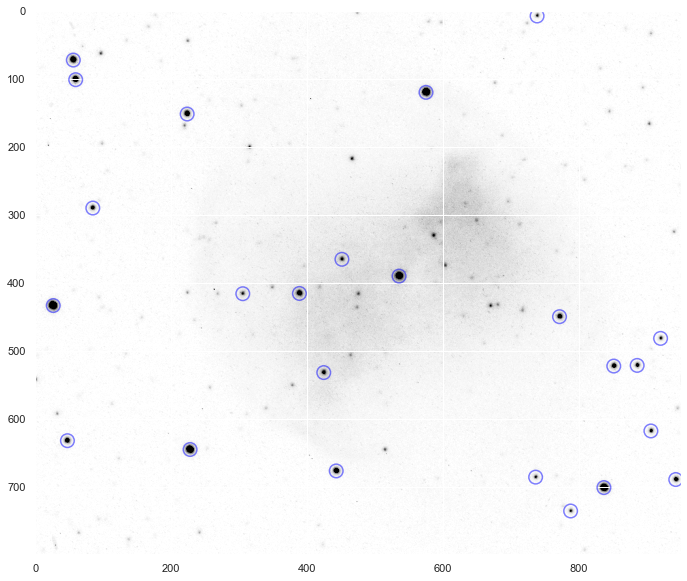

In [131]:
image = tot_db
mean, median, std = sigma_clipped_stats(image, sigma=10.0)
daofind = DAOStarFinder(fwhm=10.0, threshold = 30*std ) 
sources = daofind(image - median)


from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=10.) #choose a number large enough to go over the stars
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image, cmap='Greys',vmin =  1,vmax = 1.3)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

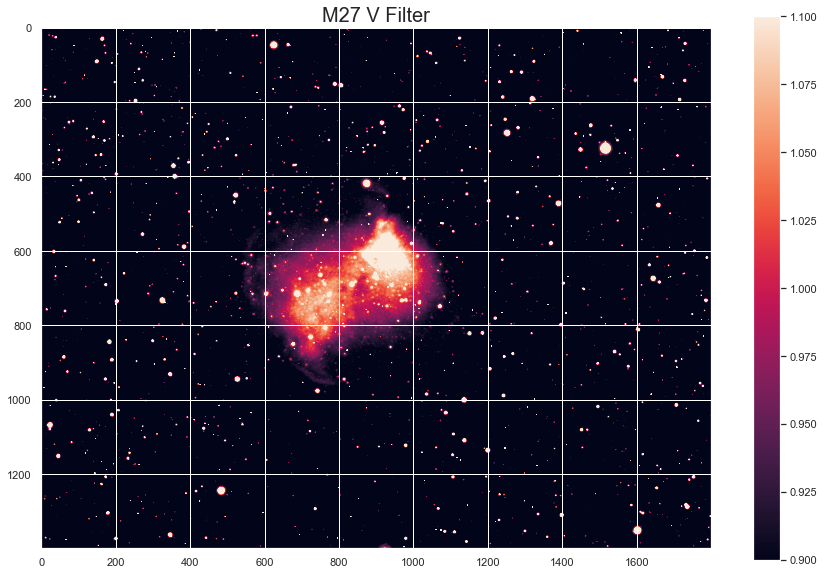

In [5]:
os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/M27_data/v2')
#rename('C:/Users/laura/Documents/4th year/Thesis/Rough work/M27_data/v2','im')

# lis = glob('im*')
# for i in range (0,len(lis)):
#     d = fits.getdata(lis[i])
#     im_n = CCDData(d, unit=u.adu)
#     im_trim = ccdproc.trim_image(im_n[350:1750,700:2500])
#     im = np.array(im_trim)
#     av = np.median(im[600:800,600:800])
#     trima = im/av
#     hdu = fits.PrimaryHDU(trima)
#     hdul = fits.HDUList([hdu])
#     name = 'trim_0{}'.format(i+1)
#     hdul.writeto(name+'.fits', overwrite = True)
# image = master('trim*')
# plt.imshow(image,vmin =  0.9,vmax = 1.1)

#source_align('trim_01.fits','trim*','M27','M27_data/v2','M27_data/v2')

# trima = master('M27_al*')
# hdu = fits.PrimaryHDU(trima)
# hdul = fits.HDUList([hdu])
# name = 'master_M27_V'
# hdul.writeto(name+'.fits', overwrite = True)

tot_dV = fits.getdata('master_M27_V.fits')
plt.imshow(tot_dV,vmin =  0.9,vmax = 1.1)

plt.colorbar()
plt.title('M27 V Filter',fontsize = 20)
os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/images')
plt.savefig('M27_V.png')
plt.show()


In [73]:
os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/M27_data/b2')
images = glob('M27_al*')
z = []
mags = []
for file in images:

    image = fits.getdata(file)
    # Set up aperture and annulus
    positions = [(875,420),(1515,322),(1390,470),(1600,1350)]

    aperture = CircularAperture(positions,r =25)
    annulus = CircularAnnulus(positions, r_in= 35., r_out=40)

    # Make a list of apertures
    apers = [aperture, annulus]

    # And run aperture photometry
    phot_table = aperture_photometry(image, apers)


    # We calculate the mean counts in each pixel in the background annulus, and then multiply by the area
    # in the aperture to get the total background counts within each aperture

    bkg_mean = (phot_table['aperture_sum_1'])/(annulus.area)

    bkg_total = bkg_mean * aperture.area


    bkg_mean = phot_table['aperture_sum_1'] / annulus.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total   

    # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum_0'] - bkg_total

    magnitudes = -2.5*np.log10(final_sum)
    #mag in B
    A= -magnitudes[0] +12.91
    B = -magnitudes[1] +11.03
    C = -magnitudes[2] +12.88
    D = -magnitudes[3] + 12.36

    zerom = np.mean([A,B,C,D])
    real_m = magnitudes + zerom


    real_m = magnitudes + zerom
    z.append(zerom)
    mags.append(real_m)


  aperture_sum_0  
------------------
15.008573267178894
  aperture_sum_0 
-----------------
9.015457946470306


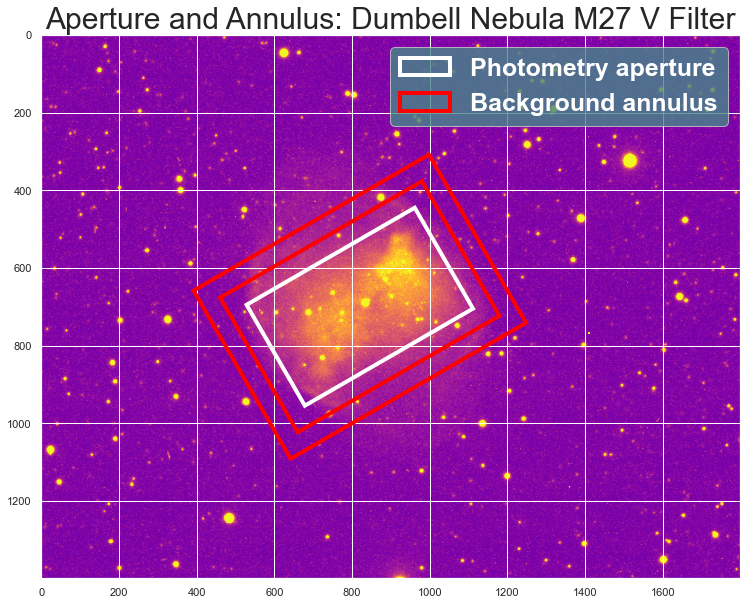

In [74]:
image = tot_db
# Set up aperture and annulus
positions = [(820,700)]

aperture = RectangularAperture(positions, 500, 300, theta=-np.pi/6)
annulus = RectangularAnnulus(positions,  600,700,500, 400, theta= -np.pi/6)

# Make a list of apertures
apers = [aperture, annulus]

# And run aperture photometry
phot_table = aperture_photometry(image, apers)


 # We calculate the mean counts in each pixel in the background annulus, and then multiply by the area
    # in the aperture to get the total background counts within each aperture

bkg_mean = (phot_table['aperture_sum_1'])/(annulus.area)

bkg_total = bkg_mean * aperture.area


bkg_mean = phot_table['aperture_sum_1'] / annulus.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total   
    # Now we get the final table of background subtracted counts within each aperture
final_sum = phot_table['aperture_sum_0'] - bkg_total
    
    
mag_B = -2.5*np.log10(final_sum)+np.mean(z)

net_star = phot_table['aperture_sum_0'] - bkg_total       
        
snr = net_star / np.sqrt(net_star + bkg_total)

print(snr)

print(mag_B)
plt.imshow(tot_db,vmin=1.05,vmax=1.2,cmap = 'plasma')
ap_patches = aperture.plot(color='white', lw=4,
                           label='Photometry aperture')
ann_patches = annulus.plot(color='red', lw=4,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.title('Aperture and Annulus: Dumbell Nebula M27 V Filter', fontsize = 30)
plt.legend(loc= 'upper right', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 25})


In [75]:
os.chdir(r'C:/Users/laura/Documents/4th year/Thesis/Rough work/M27_data/v2')
images = glob('M27_al*')
z = []
mags = []
for file in images:

    image = fits.getdata(file)
    # Set up aperture and annulus
    positions = [(875,420),(1515,322),(1390,470),(1600,1350)]

    aperture = CircularAperture(positions,r =25)
    annulus = CircularAnnulus(positions, r_in= 35., r_out=40)

    # Make a list of apertures
    apers = [aperture, annulus]

    # And run aperture photometry
    phot_table = aperture_photometry(image, apers)


    # We calculate the mean counts in each pixel in the background annulus, and then multiply by the area
    # in the aperture to get the total background counts within each aperture

    bkg_mean = (phot_table['aperture_sum_1'])/(annulus.area)

    bkg_total = bkg_mean * aperture.area


    bkg_mean = phot_table['aperture_sum_1'] / annulus.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total   

    # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum_0'] - bkg_total

    magnitudes = -2.5*np.log10(final_sum)
    #mag in B
    A= -magnitudes[0] +11.27
    B = -magnitudes[1] +10.43
    C = -magnitudes[2] +12.72
    D = -magnitudes[3] + 11.07

    zerom = np.mean([A,B,C,D])
    real_m = magnitudes + zerom


    real_m = magnitudes + zerom
    z.append(zerom)
    mags.append(real_m)


  aperture_sum_0 
-----------------
45.30024774000842
 aperture_sum_0 
----------------
8.33699802288903


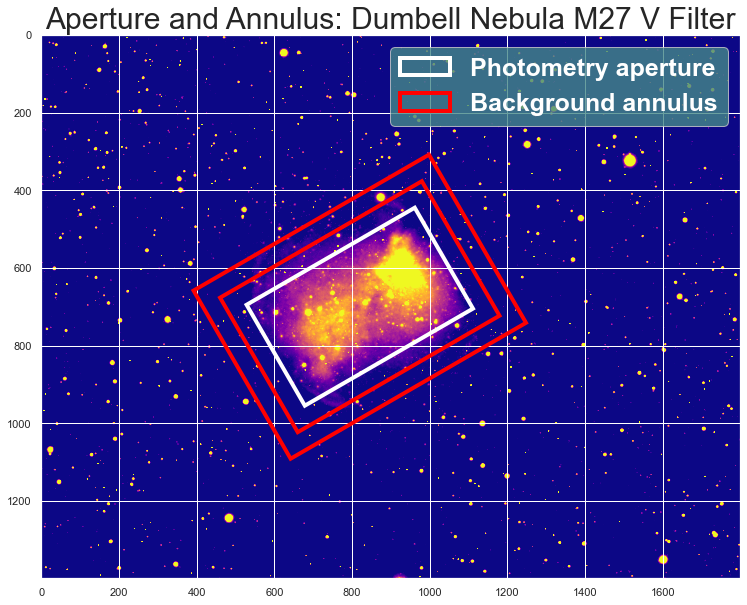

In [76]:
image = tot_dV
# Set up aperture and annulus
positions = [(820,700)]

aperture = RectangularAperture(positions, 500, 300, theta=-np.pi/6)
annulus = RectangularAnnulus(positions,  600,700,500, 400, theta= -np.pi/6)

# Make a list of apertures
apers = [aperture, annulus]

# And run aperture photometry
phot_table = aperture_photometry(image, apers)


 # We calculate the mean counts in each pixel in the background annulus, and then multiply by the area
    # in the aperture to get the total background counts within each aperture

bkg_mean = (phot_table['aperture_sum_1'])/(annulus.area)

bkg_total = bkg_mean * aperture.area


bkg_mean = phot_table['aperture_sum_1'] / annulus.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total   
    # Now we get the final table of background subtracted counts within each aperture
final_sum = phot_table['aperture_sum_0'] - bkg_total
    
    
mag_V = -2.5*np.log10(final_sum) +np.mean(z)

net_star = phot_table['aperture_sum_0'] - bkg_total       
        
snr = net_star / np.sqrt(net_star + bkg_total)
print(snr)

print(mag_V)
plt.imshow(tot_dV,vmin=0.9,vmax=1.1,cmap = 'plasma')
ap_patches = aperture.plot(color='white', lw=4,
                           label='Photometry aperture')
ann_patches = annulus.plot(color='red', lw=4,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.title('Aperture and Annulus: Dumbell Nebula M27 V Filter', fontsize = 30)
plt.legend(loc= 'upper right', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 25})

In [82]:
sloan_mag(mag_B,mag_V)

(<Column name='aperture_sum_0' dtype='float64' length=1>
 8.129118346221018,
 <Column name='aperture_sum_0' dtype='float64' length=1>
 8.631204865832052)

[18.50337323838267, 18.486489684262978, 18.5026061022134]
